# Capstone 2 - ML Modeling

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

In [ ]:
os.chdir('/content/drive/MyDrive/Capstone_2')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle, resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score
import pickle

## Model Preprocessing

### Bootstrapping and Shuffling Dataset

In [ ]:
# Reading in binary data that was pickled above
pickle_in_data = open('df_final','rb')
df = pickle.load(pickle_in_data)

In [ ]:
# Counting positive and negative reviews
count_dict = df.binary_target.value_counts().to_dict()
count_dict
# It's clear that the data set is unbalanced and heavy towards positive reviews
# For ML algorithims, it's typically best to have balanced classes
# One way to solve this is to bootstrap the negative reviews to get the same number of positive reviews

{0: 333121, 1: 1356067}

In [ ]:
# Bootstrapping negative reviews
neg = df[df['binary_target'] == 0]
neg_bs = resample(neg, 
                  replace=True, # Sample with replacement
                  n_samples=count_dict[1], # Want to have same number of postiive reviews
                  random_state=123)

In [ ]:
# Combinbing positive reviews and bootstrapped negative reviews
pos = df[df['binary_target'] == 1]
bs_df = pd.concat([pos, neg_bs])

In [ ]:
# Getting new counts of bootstrapped samples
bs_count_dict = bs_df.binary_target.value_counts().to_dict()
bs_count_dict

{0: 1356067, 1: 1356067}

In [ ]:
# # Shuffling balanced dataframe
df_shuffled = shuffle(bs_df)

In [ ]:
# Converting datatypes for memory efficiency
num_cols = ['overall', 'helpful_votes', 'overall_votes', 'pct_helpful', 'review_helpful', 'binary_target', 'review_length']
for x in num_cols:
    df_shuffled[x] = df_shuffled[x].astype('float16')

In [ ]:
# Pickling df to save time
pickle_out=open('df_shuffled', 'wb')
pickle.dump(df_shuffled, pickle_out)
pickle_out.close()

### Reading In Previously Processed Data

In [ ]:
# Reading in binary data that was pickled above
pickle_in_data = open('df_shuffled','rb')
df_shuffled = pickle.load(pickle_in_data)

In [ ]:
# Creating features and targets for models
features = df_shuffled[['helpful_votes', 'pct_helpful', 'review_Time', 'review_clean', 'review_length', 'review_clean_string']]
target = df_shuffled['binary_target']

In [ ]:
# Creating training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=123)

## Text Features

In [ ]:
# Initializing Count Vectorizer class from sklearn
vectorizer = CountVectorizer()

In [ ]:
train_text= X_train['review_clean_string'].astype('U').values
test_text = X_test['review_clean_string'].astype('U').values

In [ ]:
X_train_cv = vectorizer.fit_transform(train_text)
X_test_cv = vectorizer.transform(test_text)

In [ ]:
X_test_cv = X_test_cv.astype(np.int32)

In [ ]:
X_train_cv = X_train_cv.astype(np.int32)

### Naive Bayes Classifier

In [ ]:
from sklearn.model_selection import GridSearchCV
def NB_GridSearch(X_train, y_train):
    grid_params = {'alpha':[0.1,0.2,0.3,0.4,0.5],
                     'fit_prior': [True, False],  }

    gs = GridSearchCV( MultinomialNB(), grid_params,scoring='f1')
    gs.fit(X_train, y_train)
    print("Best Score: ", gs.best_score_)
    return gs.best_params_.values()

In [ ]:
def NaiveBayes(X_train,y_train,X_test,y_test,alpha,fit_prior):
    # fit the training dataset on the NB classifier
    Naive = MultinomialNB(alpha=0.1, fit_prior= True)
    Naive.fit(X_train,y_train)
    #prediction
    nb_train_pre=Naive.predict(X_train)
    nb_test_pre=Naive.predict(X_test)
    # Use accuracy_score function to get the accuracy
    print("Naive Bayes Train Accuracy Score :",accuracy_score(nb_train_pre, y_train))
    print("Naive Bayes Test Accuracy Score :",accuracy_score(nb_test_pre, y_test))
    # calculate f1 scores for test data and train data 
    nb_f1_score_test=f1_score(y_test,nb_test_pre)
    nb_f1_score_train=f1_score(y_train,nb_train_pre)

    print("Train data f1 score:{}".format(nb_f1_score_train))
    print("Test data f1 score:{}".format(nb_f1_score_test ))
    print("confusion_matrix:{}".format(confusion_matrix(y_test, nb_test_pre)))
    return nb_train_pre,nb_test_pre

In [ ]:
%%time
alpha1,fit_prior1=NB_GridSearch(X_train_cv, y_train)

Best Score:  0.820959602089786
Wall time: 1min 26s


In [ ]:
%%time
nb_train_prec,nb_test_prec=NaiveBayes(X_train_cv, y_train, X_test_cv, y_test, alpha1, fit_prior1)

Naive Bayes Train Accuracy Score : 0.8272554773524721
Naive Bayes Test Accuracy Score : 0.8173284146991208
Train data f1 score:0.8325038331889137
Test data f1 score:0.822561986726979
confusion_matrix:[[213671  56876]
 [ 42210 229670]]
Wall time: 3.74 s


In [ ]:
# # Pickling df to save time
with open('train.pickle', 'wb') as f:
    pickle.dump([X_train, y_train], f)

### Deep Neural Network

In [ ]:
# Creating a 3% sample of dataframe to test NN model
nn_df = df_shuffled.sample(frac=0.033, random_state=1)

In [ ]:
# Creating features and targets for models
features_nn = nn_df[['helpful_votes', 'pct_helpful', 'review_Time', 'review_clean', 'review_length', 'review_clean_string']]
target_nn = nn_df['binary_target']

In [ ]:
# Creating training and test sets
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(features_nn, target_nn, test_size=0.2, random_state=123)

In [ ]:
# Initializing Count Vectorizer class from sklearn
vectorizer = CountVectorizer()

In [ ]:
train_text_nn= X_train_nn['review_clean_string'].astype('U').values
test_text_nn = X_test_nn['review_clean_string'].astype('U').values

In [ ]:
X_train_nn = vectorizer.fit_transform(train_text_nn)
X_test_nn = vectorizer.transform(test_text_nn)

In [ ]:
X_test_nn = X_test_nn.astype(np.int32)

In [ ]:
X_train_nn = X_train_nn.astype(np.int32)

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.optimizers import Adam, SGD
import tensorflow as tf
from tqdm import tqdm

Using TensorFlow backend.


In [ ]:
from keras import regularizers
import random
def history_model(X_train, y_train,X_test, y_test):
    #Before we build our model, we need to know the input dimension of our feature vectors.
    input_dim = X_train.shape[1] 
    # Add layers one by one in order 
    random.seed(123)
    model = Sequential()
    model.add(keras.layers.Dense(10, input_dim=input_dim, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    opt = SGD(lr=0.01, momentum=0.9)
    #specify the optimizer and the loss function.
    model.compile(loss='binary_crossentropy', 
                  optimizer=opt, 
                  metrics=['accuracy'])

    #Give an overview of the model and the number of parameters available for training:
    model.summary()
    # # fit the model
    history = model.fit(X_train, y_train,epochs=50, verbose=1,
                    validation_data=(X_test, y_test),batch_size=70)
    return history, model

In [ ]:
def nn_result_prediction(X_train, y_train,X_test, y_test,model):
    # obtian Accuracies for train data and test data
    loss1, accuracy1 = model.evaluate(X_train, y_train, verbose=False)
    print("Training Accuracy: {:.4f}".format(accuracy1))
    loss2, accuracy2 = model.evaluate(X_test, y_test, verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy2))
    #prediction
    nn_train_pre=model.predict_classes(X_train)
    nn_test_pre=model.predict_classes(X_test)

    # calculate f1 scores for test data and train data 
    nn_f1_score_test=f1_score(y_test,nn_test_pre)
    nn_f1_score_train=f1_score(y_train,nn_train_pre)

    print("Train data f1 score:{}".format(nn_f1_score_train))
    print("Test data f1 score:{}".format(nn_f1_score_test ))
    print("confusion_matrix:{}".format(confusion_matrix(y_test, nn_test_pre)))
    return nn_train_pre,nn_test_pre

In [ ]:
historyc, modelc=history_model(X_train_nn, y_train_nn, X_test_nn, y_test_nn)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 10)                682210    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 682,221
Trainable params: 682,221
Non-trainable params: 0
_________________________________________________________________
Train on 71600 samples, validate on 17900 samples
Epoch 1/50
71600/71600 [==============================] - 36s 503us/step - loss: 0.4607 - accuracy: 0.7992 - val_loss: 0.4063 - val_accuracy: 0.8235
Epoch 2/50
71600/71600 [==============================] - 37s 523us/step - loss: 0.3820 - accuracy: 0.8357 - val_loss: 0.3912 - val_accuracy: 0.8322
Epoch 3/50
71600/71600 [==============================] - 38s 527us/step - loss: 0.3568 - accuracy: 0.8463 - val_loss: 0.3773 - val_accuracy: 0.8348
Epoch 4/50
71

In [ ]:
# Will need cloud GPU to train full dataset

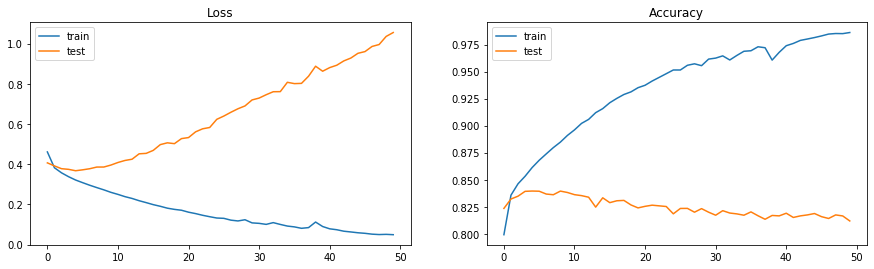

In [ ]:
# plot loss during training
plt.figure(figsize=(15,9))
plt.subplot(2,2,1)
plt.title('Loss')
plt.plot(historyc.history['loss'], label='train')
plt.plot(historyc.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(2,2,2)
plt.title('Accuracy')
plt.plot(historyc.history['accuracy'], label='train')
plt.plot(historyc.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [ ]:
# create a function to show the resunlts
from sklearn.metrics import confusion_matrix

def nn_result_prediction(X_train, y_train,X_test, y_test,model): 
    #prediction
    nn_train_pre=model.predict_classes(X_train)
    nn_test_pre=model.predict_classes(X_test)
    # calculate f1 scores for test data and train data 
    nn_f1_score_test=f1_score(y_test,nn_test_pre)
    nn_f1_score_train=f1_score(y_train,nn_train_pre)
    print("Train data f1 score:{}".format(round(nn_f1_score_train, ndigits=5)))
    print("Test data f1 score:{}".format(round(nn_f1_score_test, ndigits=5)))
    
    print("confusion_matrix:{}".format(confusion_matrix(y_test, nn_test_pre)))

    return nn_train_pre,nn_test_pre

In [ ]:
# using the function above to show the result
nn_train_prec,nn_test_prec=nn_result_prediction(X_train_nn, y_train_nn, X_test_nn, y_test_nn,modelc)

Train data f1 score:0.98704
Test data f1 score:0.81349
confusion_matrix:[[7190 1836]
 [1531 7343]]


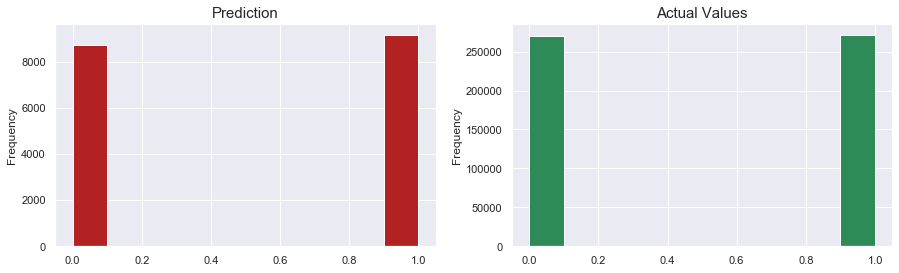

In [ ]:
# figure size 
plt.figure(figsize=(15,9))
# subplot for prediction
plt.subplot(2,2,1)
pd.Series([x[0] for x in nn_test_prec]).plot(kind='hist',color='firebrick')
plt.title('Prediction',fontsize=15)
# subplot for actual values 
plt.subplot(2,2,2)
y_test.plot(kind='hist',color='seagreen')
plt.title('Actual Values',fontsize=15)

plt.show()

### Logistic Regression

In [ ]:
#import Logistic Regression
from sklearn.linear_model import LogisticRegression

def Logistic_Regression(X_train, y_train,X_test, y_test):
    log_re = LogisticRegression(max_iter=1000)
    log_re.fit(X_train, y_train)
    #calculate scores for test data and train data 
    test_data_score = log_re.score(X_test, y_test)
    train_data_score = log_re.score(X_train, y_train)
    print("Train data score:{}".format(train_data_score ))
    print("Test data score:{}".format(test_data_score ))
    # predict values for test data and train data
    log_y_test_pre=log_re.predict(X_test)
    log_y_train_pre=log_re.predict(X_train)
    # calculate f1 scores for test data and train data 
    log_f1_score_test=f1_score(y_test,log_y_test_pre)
    log_f1_score_train=f1_score(y_train,log_y_train_pre)

    print("Train data f1 score:{}".format(log_f1_score_train))
    print("Test data f1 score:{}".format(log_f1_score_test ))
    return log_y_train_pre,log_y_test_pre

In [ ]:
%%time
log_y_train_prec,log_y_test_prec=Logistic_Regression(X_train_cv, y_train,X_test_cv, y_test)

C:\Users\ZachP\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Train data score:0.8859062537015366
Test data score:0.8714776366220708
Train data f1 score:0.8865584997035078
Test data f1 score:0.8721491501551508
Wall time: 14min 46s


### Results for Text Models

In [ ]:
# compare all the models 
# f1_Score of each model has no big difference. 
# Logistic Regression model gives the best result
text_results=pd.DataFrame()
text_results['Model']=['Navie Bayes','Deep Neural Netwrok','Logistic Regression',]
text_results['f1_score (test)']=[0.8225,0.8134,0.8721]
text_results

,Model,f1_score (test)
0,Navie Bayes,0.8225
1,Deep Neural Netwrok,0.8134
2,Logistic Regression,0.8721


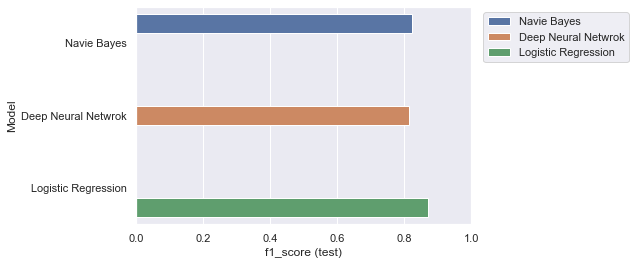

In [ ]:
import seaborn as sns
_ = sns.barplot(data=text_results, y='Model', x='f1_score (test)', hue='Model', orient = 'h', saturation=0.75)
_ = plt.xlim(0,1)
_ = plt.legend(bbox_to_anchor=(1.02, 1), loc=2)
_ = plt.show()

## Numerical Features

In [ ]:
#  Creating training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=123)

In [ ]:
# Creating copies of train and test df's
X_train_num = X_train.copy(deep=False)
X_test_num = X_test.copy(deep=False)

In [ ]:
import datetime 
import time

# Converting to timestatmp for modelling
X_train_num['ts'] = X_train_num['review_Time'].values.astype(np.int64) // 10**9
X_test_num['ts'] = X_test_num['review_Time'].values.astype(np.int64) // 10**9

X_train_num = X_train_num[['helpful_votes', 'pct_helpful', 'ts', 'review_length']]
X_test_num = X_test_num[['helpful_votes', 'pct_helpful', 'ts', 'review_length']]

In [ ]:
# # Pickling numerical training/test data to save time
with open('num_train_data', 'wb') as f:
    pickle.dump([X_train_num, X_test_num, y_train, y_test], f)

In [ ]:
# Reading in binary data that was pickled above
pickle_in_data = open('num_train_data','rb')
X_train_num, X_test_num, y_train, y_test = pickle.load(pickle_in_data)

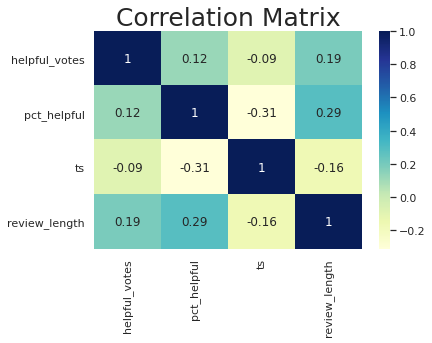

In [ ]:
# Correlation matrix
import seaborn as sns
X_train_cor=pd.DataFrame(data=X_train_num, columns=X_train_num.columns)
sns.set(style="white")
sns.heatmap(X_train_cor.corr(),cmap="YlGnBu", annot=True)
plt.title("Correlation Matrix".title(),fontsize=25)
plt.show()

# review helpfullness is positively correlated with review length
# also, all of the feautres negativley correlate with time

In [ ]:
# Scaling and standardizing data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()  

scaler.fit(X_train_num)

X_train_num = scaler.transform(X_train_num)  
X_test_num = scaler.transform(X_test_num)

### Models being used for numerical data
- Logistic Regression
- Deep Neural Network
- Random Forest

### Logistic Regression

In [ ]:
# Instantiating the Logistic Regression classifier and fitting features
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train_num, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Scoring the training and testing sets
test_num_score = log_reg.score(X_test_num, y_test)
train_num_score = log_reg.score(X_train_num, y_train)
print("Train data score:{}".format(train_num_score))
print("Test data score:{}".format(test_num_score))

Train data score:0.5441614927729873
Test data score:0.5443958357530138


In [ ]:
# predict values for test data and train data
test_pred = log_reg.predict(X_test_num)
train_pred = log_reg.predict(X_train_num)
# calculate f1 scores for test data and train data 
f1_score_test = f1_score(y_test,test_pred)
f1_score_train = f1_score(y_train,train_pred)

print("Train data f1 score:{}".format(f1_score_train))
print("Test data f1 score:{}".format(f1_score_test))

Train data f1 score:0.5916884163454099
Test data f1 score:0.592225063938619


In [ ]:
# These results are not very good comapred to the text models

### Deep Neural Network

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.optimizers import Adam, SGD
import tensorflow as tf
from tqdm import tqdm

#Before we build our model, we need to know the input dimension of our feature vectors.
input_num_dim = X_train_num.shape[1] 
input_num_dim
# Add layers one by one in order 
model_num = Sequential()
model_num.add(keras.layers.Dense(10, input_dim=input_num_dim, activation='relu'))
model_num.add(keras.layers.Dense(1, activation='sigmoid'))
opt = SGD(lr=0.01, momentum=0.9)


#specify the optimizer and the loss function.
model_num.compile(loss='binary_crossentropy', 
              optimizer=opt, 
              metrics=['accuracy'])

#Give an overview of the model and the number of parameters available for training:
model_num.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                50        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit the model
history_num = model_num.fit(X_train_num, y_train,epochs=50, verbose=1,
                    validation_data=(X_test_num, y_test),batch_size=70)

In [ ]:
# obtian Accuracies for train data and test data
loss_num_train, accuracy_num_train = model_num.evaluate(X_train_num, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy_num_train))
loss_num_test, accuracy_num_test = model_num.evaluate(X_test_num, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy_num_test))

Training Accuracy: 0.5990
Testing Accuracy:  0.5995


In [ ]:
#prediction
nn_num_train_pre=model_num.predict_classes(X_train_num)
nn_num_test_pre=model_num.predict_classes(X_test_num)
# calculate f1 scores for test data and train data 
nn_f1_score_num_test=f1_score(y_test,nn_num_test_pre)
nn_f1_score_num_train=f1_score(y_train,nn_num_train_pre)

print("Train data f1 score:{}".format(nn_f1_score_num_train))
print("Test data f1 score:{}".format(nn_f1_score_num_test ))

Train data f1 score:0.6351890260318077
Test data f1 score:0.6358207453853504


### Random Forest

In [ ]:
# create the classifier
rfc = RandomForestClassifier(n_estimators=100)

In [ ]:
# Train the model using the training sets
%%time
rfc.fit(X_train_num, y_train)

CPU times: user 8min 40s, sys: 3.87 s, total: 8min 44s
Wall time: 8min 44s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
   # predictin on the test set
y_pred = rfc.predict(X_test_num)

In [ ]:
# Calculate Model Accuracy
print("Accuracy of test data:", accuracy_score(y_test, y_pred))

Accuracy of test data: 0.7536387384846256


In [ ]:
# Score for train and test data 
print("Score of train data :" ,rfc.score(X_train_num,y_train))
print("Score of test data :" ,rfc.score(X_test_num,y_test))

Score of train data : 0.8331760924401314
Score of test data : 0.7536387384846256


In [ ]:
rfc_train_pred= rfc.predict(X_train_num)
rfc_test_pred= rfc.predict(X_test_num)
f1_score_train=f1_score(list(y_train),rfc_train_pred)
f1_score_test=f1_score(list(y_test),rfc_test_pred)
print("F1 Score of train data :" , f1_score_train)
print("F1 Score of test data :" ,f1_score_test)

F1 Score of train data : 0.8363214089167909
F1 Score of test data : 0.7489248332058853


In [ ]:
# Reading in binary data that was pickled above
pickle_in_data = open('num_train_data','rb')
X_train_num, X_test_num, y_train, y_test = pickle.load(pickle_in_data)

In [ ]:
# check Important features
feature_importances_df = pd.DataFrame(
    {"feature": list(X_train_num.columns), "importance": rfc.feature_importances_}
).sort_values("importance", ascending=False)

# Display
feature_importances_df

,feature,importance
2,ts,0.659303
3,review_length,0.211754
1,pct_helpful,0.082599
0,helpful_votes,0.046344


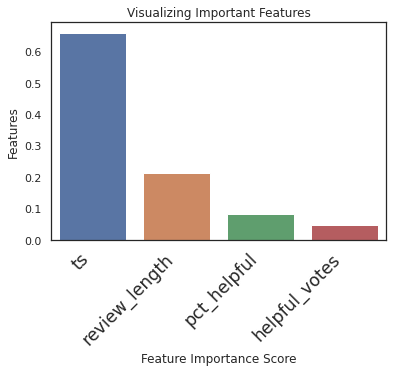

In [ ]:
# visualize important featuers

# Creating a bar plot
sns.barplot(x=feature_importances_df.feature, y=feature_importances_df.importance)
# Add labels to your

plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Visualizing Important Features")
plt.xticks(
    rotation=45, horizontalalignment="right", fontweight="light", fontsize="x-large"
)
plt.show()

### Numerical Model Results

In [ ]:
# compare all the models 
# f1_Score of each model has no big difference. 
# Logistic Regression model gives the best result
num_results=pd.DataFrame()
num_results['Model']=['Logistic Regression','Deep Neural Netwrok','Random Forest',]
num_results['f1_score (test)']=[0.5922,0.6358,0.7489]
num_results

,Model,f1_score (test)
0,Logistic Regression,0.5922
1,Deep Neural Netwrok,0.6358
2,Random Forest,0.7489


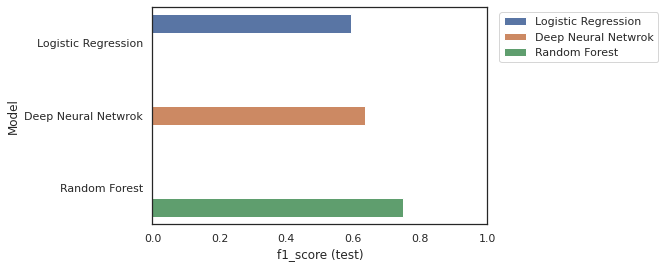

In [ ]:
import seaborn as sns
_ = sns.barplot(data=num_results, y='Model', x='f1_score (test)', hue='Model', orient = 'h', saturation=0.75)
_ = plt.xlim(0,1)
_ = plt.legend(bbox_to_anchor=(1.02, 1), loc=2)
_ = plt.show()